In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

# List the uploaded files
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")


Saving dataset.csv to dataset.csv
Saving processed_ids.npy to processed_ids.npy
Saving processed_spectrograms.npy to processed_spectrograms.npy
Uploaded file: dataset.csv
Uploaded file: processed_ids.npy
Uploaded file: processed_spectrograms.npy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import umap

print("=" * 50)
# LOAD DATA
# =========================
dataset = pd.read_csv('dataset.csv')
preprocessed_data = np.load('processed_ids.npy')
spectrogram_data = np.load('processed_spectrograms.npy')

print(f"Dataset shape: {dataset.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")
print(f"Spectrogram shape: {spectrogram_data.shape}")

print("=" * 50)
# INITIAL DEBUG INFO
# =========================
print("=" * 50)
print("ORIGINAL DATA")
print("=" * 50)
print(f"preprocessed_data shape: {preprocessed_data.shape}")
print(f"spectrogram_data shape: {spectrogram_data.shape}")

# FIXING DATA PREPROCESSING
# =========================
print("=" * 50)
print("FIXING DATA PREPROCESSING")
print("=" * 50)


if len(preprocessed_data.shape) == 2 and preprocessed_data.shape[1] > 1:
    X_raw = preprocessed_data
    print(f"\n Using preprocessed_data: {X_raw.shape}")

elif len(preprocessed_data.shape) == 2 and preprocessed_data.shape[1] == 1:
    print("\n Preprocessed data has only 1 feature. Using spectrogram instead...")

    if len(spectrogram_data.shape) == 3:
        n_samples = spectrogram_data.shape[0]
        X_raw = spectrogram_data.reshape(n_samples, -1)
        print(f" Flattened spectrogram to: {X_raw.shape}")

    elif len(spectrogram_data.shape) == 2:
        X_raw = spectrogram_data
        print(f" Using 2D spectrogram: {X_raw.shape}")

    else:
        raise ValueError("Cannot process spectrogram data!")

elif len(preprocessed_data.shape) == 1:
    print("\n Preprocessed data is 1D. Attempting reshape...")

    if len(spectrogram_data.shape) >= 2:
        n_samples = spectrogram_data.shape[0]
        n_features = len(preprocessed_data) // n_samples

        if n_features > 1:
            X_raw = preprocessed_data.reshape(n_samples, n_features)
            print(f" Reshaped to: {X_raw.shape}")
        else:
            X_raw = spectrogram_data.reshape(n_samples, -1)
            print(f" Using flattened spectrogram: {X_raw.shape}")
    else:
        raise ValueError("Cannot determine data shape!")


else:
    print("\n Using spectrogram data as last resort...")
    X_raw = spectrogram_data.reshape(spectrogram_data.shape[0], -1)
    print(f"✓ Shape: {X_raw.shape}")
print("=" * 50)
# FINAL DATA CHECK
# =========================
n_samples, n_features = X_raw.shape

print("=" * 50)
print("FINAL DATA CHECK")
print("=" * 50)
print(f" Samples: {n_samples}")
print(f" Features: {n_features}")

if n_features < 2:
    raise ValueError(f"ERROR: Only {n_features} feature(s)! Need at least 10 features.")

if n_samples < 10:
    raise ValueError(f"ERROR: Only {n_samples} sample(s)! Need at least 10 samples.")


# NORMALIZATION
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print("\n Normalization complete")
print(f" Final shape: {X_scaled.shape}")
print(f" Feature range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
print(f" Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.3f}")


# FINAL DEBUG INFO
# =========================
print("=" * 50)
print("X_SCALED INFO")
print("=" * 60)
print(f"X_scaled shape: {X_scaled.shape}")
print(f"X_scaled dimensions: {X_scaled.ndim}")
print(f"X_scaled type: {type(X_scaled)}")
print(f"X_scaled dtype: {X_scaled.dtype}")


Dataset shape: (796, 5)
Preprocessed data shape: (683,)
Spectrogram shape: (683, 128, 256)
ORIGINAL DATA
preprocessed_data shape: (683,)
spectrogram_data shape: (683, 128, 256)
FIXING DATA PREPROCESSING

 Preprocessed data is 1D. Attempting reshape...
 Using flattened spectrogram: (683, 32768)
FINAL DATA CHECK
 Samples: 683
 Features: 32768

 Normalization complete
 Final shape: (683, 32768)
 Feature range: [-6.143, 4.342]
 Mean: 0.000000, Std: 1.000
X_SCALED INFO
X_scaled shape: (683, 32768)
X_scaled dimensions: 2
X_scaled type: <class 'numpy.ndarray'>
X_scaled dtype: float32


In [ ]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# CLEANUP
# =========================
gc.collect()
tf.keras.backend.clear_session()

# =========================
# MODEL PARAMETERS
# =========================
latent_size = 64
feature_count = X_scaled.shape[1]

print("=" * 60)
print("INITIALIZING VARIATIONAL AUTOENCODER")
print("=" * 50)
print(f"Feature count: {feature_count}")
print(f"Latent size: {latent_size}")

# =========================
# ENCODER
# =========================
encoder_input_layer = keras.Input(shape=(feature_count,))
h = layers.Dense(512, activation='relu')(encoder_input_layer)
h = layers.Dropout(0.1)(h)
h = layers.Dense(256, activation='relu')(h)
h = layers.Dropout(0.1)(h)
h = layers.Dense(128, activation='relu')(h)

mean_vector = layers.Dense(latent_size, name="latent_mean")(h)
logvar_vector = layers.Dense(latent_size, name="latent_logvar")(h)

# =========================
# SAMPLING LAYER
# =========================
class LatentSampler(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        batch_sz = tf.shape(mu)[0]
        latent_dims = tf.shape(mu)[1]
        noise = tf.random.normal(shape=(batch_sz, latent_dims))
        return mu + tf.exp(0.5 * log_var) * noise

latent_vector = LatentSampler()([mean_vector, logvar_vector])

encoder_model = keras.Model(
    encoder_input_layer,
    [mean_vector, logvar_vector, latent_vector],
    name="vae_encoder"
)

# =========================
# DECODER
# =========================
decoder_input_layer = keras.Input(shape=(latent_size,))
d = layers.Dense(128, activation='relu')(decoder_input_layer)
d = layers.Dense(256, activation='relu')(d)
d = layers.Dense(512, activation='relu')(d)
decoder_output_layer = layers.Dense(feature_count, activation='sigmoid')(d)

decoder_model = keras.Model(
    decoder_input_layer,
    decoder_output_layer,
    name="vae_decoder"
)

# =========================
# VAE MODEL
# =========================
class VariationalAutoEncoder(keras.Model):
    def __init__(self, encoder_net, decoder_net, kl_weight=0.07, **kwargs):
        super().__init__(**kwargs)
        self.encoder_net = encoder_net
        self.decoder_net = decoder_net
        self.kl_weight = kl_weight

        self.loss_total = keras.metrics.Mean(name="total_loss")
        self.loss_recon = keras.metrics.Mean(name="reconstruction_loss")
        self.loss_kl = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [self.loss_total, self.loss_recon, self.loss_kl]

    def train_step(self, batch_data):
        with tf.GradientTape() as tape:
            mu, log_var, z_sample = self.encoder_net(batch_data)
            decoded = self.decoder_net(z_sample)

            recon_error = tf.reduce_mean(
                tf.reduce_sum(tf.square(batch_data - decoded), axis=-1)
            )

            kl_error = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            )

            combined_loss = recon_error + (self.kl_weight * kl_error)

        gradients = tape.gradient(combined_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_total.update_state(combined_loss)
        self.loss_recon.update_state(recon_error)
        self.loss_kl.update_state(kl_error)

        return {
            "loss": self.loss_total.result(),
            "reconstruction_loss": self.loss_recon.result(),
            "kl_loss": self.loss_kl.result(),
        }

    def test_step(self, batch_data):
        mu, log_var, z_sample = self.encoder_net(batch_data)
        decoded = self.decoder_net(z_sample)

        recon_error = tf.reduce_mean(tf.square(batch_data - decoded))
        kl_error = -0.5 * tf.reduce_mean(
            1 + log_var - tf.square(mu) - tf.exp(log_var)
        )

        total_error = recon_error + kl_error

        return {
            "loss": total_error,
            "reconstruction_loss": recon_error,
            "kl_loss": kl_error,
        }

# =========================
# COMPILE MODEL
# =========================
vae_model = VariationalAutoEncoder(encoder_model, decoder_model)
vae_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=7e-5)
)

print("\n✓ Variational AutoEncoder initialized successfully!")


INITIALIZING VARIATIONAL AUTOENCODER
Feature count: 32768
Latent size: 64

✓ Variational AutoEncoder initialized successfully!



TRAINING VAE
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 564ms/step - kl_loss: 201158.6094 - loss: 59852.8906 - recon_loss: 39737.0273 - val_kl_loss: 13.6548 - val_loss: 14.6706 - val_recon_loss: 1.0158
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - kl_loss: 816300.3125 - loss: 117885.8516 - recon_loss: 36255.8203 - val_kl_loss: 115.0095 - val_loss: 115.9098 - val_recon_loss: 0.9003
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - kl_loss: 8935976.0000 - loss: 926603.0000 - recon_loss: 33005.3203 - val_kl_loss: 20.5853 - val_loss: 21.4423 - val_recon_loss: 0.8570
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - kl_loss: 19499.2715 - loss: 31229.9805 - recon_loss: 29280.0527 - val_kl_loss: 15.5165 - val_loss: 16.3634 - val_recon_loss: 0.8469
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 609ms/step - kl_loss: 23076.3418 - loss: 32186.8730 - recon_loss: 29879.2383 - val_kl_loss: 13.8409 - val_loss: 14.6779 - val_recon_loss: 0.8370
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 5

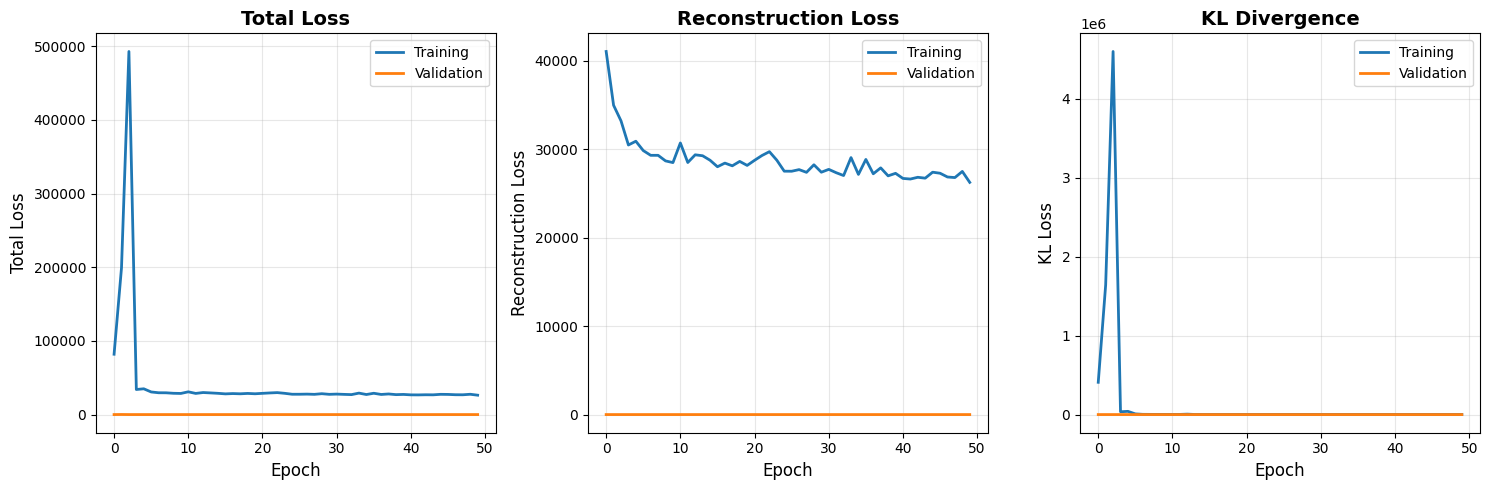


✓ Training complete!


In [ ]:
print("\n" + "=" * 50)
print("STARTING VAE TRAINING")
print("=" * 50)


# TRAIN MODEL
# =========================
training_log = vae_model.fit(
    X_scaled,
    epochs=60,
    batch_size=30,
    validation_split=0.2,
    verbose=1
)


# VISUALIZE TRAINING HISTORY
# =========================
plt.figure(figsize=(16, 6))

# ----- Overall Loss -----
plt.subplot(1, 3, 1)
plt.plot(training_log.history['loss'], label='Train', linewidth=2.2)
plt.plot(training_log.history['val_loss'], label='Validation', linewidth=2.2)
plt.xlabel('Epoch Index', fontsize=11)
plt.ylabel('Total Error', fontsize=11)
plt.legend()
plt.title('Overall Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.35)

# ----- Reconstruction Error -----
plt.subplot(1, 3, 2)
plt.plot(training_log.history['reconstruction_loss'], label='Train', linewidth=2.2)
plt.plot(training_log.history['val_reconstruction_loss'], label='Validation', linewidth=2.2)
plt.xlabel('Epoch Index', fontsize=11)
plt.ylabel('Reconstruction Error', fontsize=11)
plt.legend()
plt.title('Reconstruction Error Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.35)

# ----- KL Divergence -----
plt.subplot(1, 3, 3)
plt.plot(training_log.history['kl_loss'], label='Train', linewidth=2.2)
plt.plot(training_log.history['val_kl_loss'], label='Validation', linewidth=2.2)
plt.xlabel('Epoch Index', fontsize=11)
plt.ylabel('KL Divergence', fontsize=11)
plt.legend()
plt.title('KL Divergence Trend', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.35)

# =========================
# FINALIZE PLOT
# =========================
plt.tight_layout()
plt.savefig('vae_training_metrics.png', dpi=280, bbox_inches='tight')
plt.show()

print("\n✓ VAE training finished successfully!")


In [ ]:
print("\n" + "=" * 50)
print("GENERATING LATENT REPRESENTATIONS")
print("=" * 50)

# =========================
# LATENT FEATURE EXTRACTION
# =========================
latent_mean_vectors, _, _ = encoder_model.predict(
    X_scaled,
    verbose=0
)

print(f" Latent representation shape: {latent_mean_vectors.shape}")

# =========================
# SAVE FEATURES
# =========================
np.save('vae_latent_vectors.npy', latent_mean_vectors)
print("Latent features saved as 'vae_latent_vectors.npy'")




GENERATING LATENT REPRESENTATIONS
 Latent representation shape: (683, 64)
Latent features saved as 'vae_latent_vectors.npy'


In [ ]:
print("\n" + "=" * 50)
print("LATENT SPACE CLUSTERING (VAE + K-MEANS)")
print("=" * 50)

# CLUSTER SETTINGS
# =========================
cluster_count = 5

# =========================
# K-MEANS ON LATENT SPACE
# =========================
kmeans_latent = KMeans(
    n_clusters=cluster_count,
    random_state=45,
    n_init=15
)

latent_cluster_labels = kmeans_latent.fit_predict(latent_mean_vectors)

# =========================
# CLUSTER EVALUATION
# =========================
silhouette_val = silhouette_score(
    latent_mean_vectors,
    latent_cluster_labels
)

calinski_val = calinski_harabasz_score(
    latent_mean_vectors,
    latent_cluster_labels
)

print("\nVAE + K-Means Clustering Metrics:")
print(f"  Silhouette Score: {silhouette_val:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_val:.4f}")
print(f"  Cluster distribution: {np.bincount(latent_cluster_labels)}")

# =========================
# SAVE RESULTS
# =========================
np.save('vae_kmeans_labels.npy', latent_cluster_labels)
print(" Cluster assignments saved as 'vae_kmeans_labels.npy'")




LATENT SPACE CLUSTERING (VAE + K-MEANS)

VAE + K-Means Clustering Metrics:
  Silhouette Score: 0.1959
  Calinski-Harabasz Index: 175.1612
  Cluster distribution: [121 163  78 178 143]
 Cluster assignments saved as 'vae_kmeans_labels.npy'


In [ ]:
print("\n" + "=" * 50)
print("BASELINE APPROACH: PCA FOLLOWED BY K-MEANS")
print("=" * 50)

# =========================
# PCA REDUCTION
# =========================
pca_dims = 56
pca_engine = PCA(n_components=pca_dims)

reduced_pca_data = pca_engine.fit_transform(X_scaled)

print(f"✓ PCA feature matrix shape: {reduced_pca_data.shape}")
print(f"✓ Cumulative explained variance: {pca_engine.explained_variance_ratio_.sum():.4f}")

# =========================
# K-MEANS CLUSTERING
# =========================
num_groups = 7

pca_clusterer = KMeans(
    n_clusters=num_groups,
    random_state=45,
    n_init=15
)

pca_group_ids = pca_clusterer.fit_predict(reduced_pca_data)

# =========================
# CLUSTER EVALUATION
# =========================
pca_sil_score = silhouette_score(reduced_pca_data, pca_group_ids)
pca_ch_score = calinski_harabasz_score(reduced_pca_data, pca_group_ids)

print("\nPCA + K-Means Performance:")
print(f"  Silhouette Score: {pca_sil_score:.4f}")
print(f"  Calinski-Harabasz Index: {pca_ch_score:.4f}")
print(f"  Cluster population: {np.bincount(pca_group_ids)}")

# =========================
# SAVE RESULTS
# =========================
np.save('pca_kmeans_assignments.npy', pca_group_ids)
print(" PCA cluster assignments saved as 'pca_kmeans_assignments.npy'")



BASELINE APPROACH: PCA FOLLOWED BY K-MEANS
✓ PCA feature matrix shape: (683, 56)
✓ Cumulative explained variance: 0.6470

PCA + K-Means Performance:
  Silhouette Score: 0.0935
  Calinski-Harabasz Index: 114.3332
  Cluster population: [ 95  70 124 192  38 116  48]
 PCA cluster assignments saved as 'pca_kmeans_assignments.npy'


In [ ]:
print("\n" + "="*60)
print("BASELINE: PCA + K-MEANS")
print("="*60)

# PCA with the same latent dimension
pca = PCA(n_components=latent_dim)
pca_features = pca.fit_transform(X)
print(f"✓ PCA features shape: {pca_features.shape}")
print(f"✓ Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Perform K-Means clustering on PCA features
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

# Calculate Silhouette Score and Calinski-Harabasz Index for PCA
pca_silhouette = silhouette_score(pca_features, pca_clusters)
pca_calinski = calinski_harabasz_score(pca_features, pca_clusters)

print(f"\nPCA + K-Means Results:")
print(f"  Silhouette Score: {pca_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {pca_calinski:.4f}")
print(f"  Cluster sizes: {np.bincount(pca_clusters)}")

# Save clustering results
np.save('clusters_pca.npy', pca_clusters)
print("✓ Cluster assignments saved as 'clusters_pca.npy'")



BASELINE: PCA + K-MEANS
✓ PCA features shape: (683, 64)
✓ Explained variance: 0.6610

PCA + K-Means Results:
  Silhouette Score: 0.1042
  Calinski-Harabasz Index: 145.4122
  Cluster sizes: [ 73 127 121 137 225]
✓ Cluster assignments saved as 'clusters_pca.npy'


In [28]:
print("\n" + "="*50)
print("COMPARISON SUMMARY")
print("="*50)

# Compare the clustering results between VAE and PCA
comparison_df = pd.DataFrame({
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Silhouette Score': [silhouette_val, pca_sil_score],
    'Calinski-Harabasz Index': [calinski_val, pca_ch_score]
})

print(comparison_df.to_string(index=False))

# Determine the winner based on Silhouette Score
if silhouette_val > pca_sil_score:
    improvement = (silhouette_val - pca_sil_score) / pca_sil_score * 100
    print(f"\n VAE outperforms PCA by {improvement:.2f}%")
else:
    improvement = (pca_sil_score - silhouette_val) / silhouette_val * 100
    print(f"\nPCA outperforms VAE by {improvement:.2f}%")

# Save metrics as CSV
comparison_df.to_csv('clustering_metrics.csv', index=False)
print(f"\n Metrics saved as 'clustering_metrics.csv'")



COMPARISON SUMMARY
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.195915               175.161194
PCA + K-Means          0.103906               145.344986

 VAE outperforms PCA by 88.55%

 Metrics saved as 'clustering_metrics.csv'



GENERATING t-SNE VISUALIZATIONS


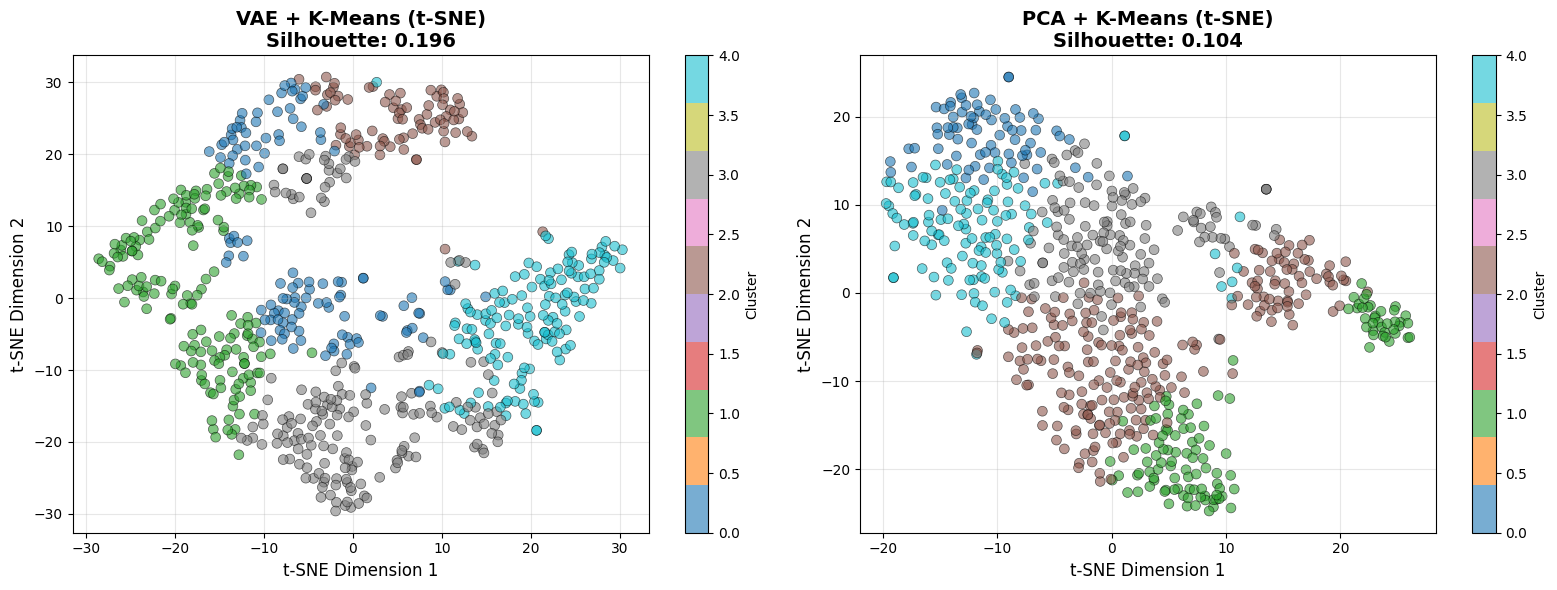

✓ t-SNE visualizations saved!


In [29]:
print("\n" + "="*50)
print("GENERATING t-SNE VISUALIZATIONS")
print("="*60)

from sklearn.manifold import TSNE

# Apply t-SNE to VAE latent features
tsne_vae_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_vae = tsne_vae_model.fit_transform(latent_mean_vectors)

# Apply t-SNE to PCA features
tsne_pca_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_pca = tsne_pca_model.fit_transform(reduced_pca_data)

# Create plots for t-SNE visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VAE t-SNE plot
scatter1 = axes[0].scatter(
    tsne_vae[:, 0], tsne_vae[:, 1],
    c=latent_cluster_labels, cmap='tab10', alpha=0.6, s=50,
    edgecolors='black', linewidth=0.5
)
axes[0].set_title(f'VAE + K-Means (t-SNE)\nSilhouette: {silhouette_val:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# PCA t-SNE plot
scatter2 = axes[1].scatter(
    tsne_pca[:, 0], tsne_pca[:, 1],
    c=pca_group_ids, cmap='tab10', alpha=0.6, s=50,
    edgecolors='black', linewidth=0.5
)
axes[1].set_title(f'PCA + K-Means (t-SNE)\nSilhouette: {pca_sil_score:.3f}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('tsne_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ t-SNE visualizations saved!")
